- (4) MNIST - 3 mal und dann Train / Test Vergleich der Klassifikation, FP, NP etc
	- MDS
	- PCA
	- Clustering

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = pd.read_csv("../data/mnist.csv")

train, test = train_test_split(data, test_size=0.25)

train_images = train.drop(columns=["label"])
train_labels = train["label"]

test_images = test.drop(columns=["label"])
test_labels = test["label"]

other_data = datasets.load_digits()
#labels = other_data.target
#images = other_data.data


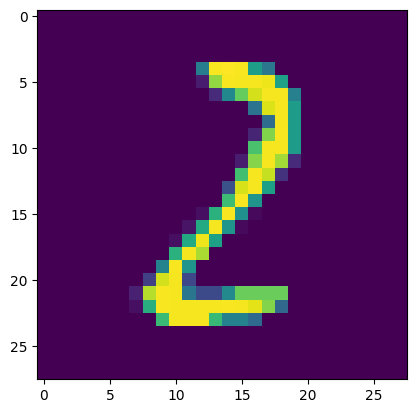

In [11]:
img = test_images.sample(1)
plt.imshow(img.to_numpy().reshape(28, 28))

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE, SpectralEmbedding, MDS

pca = PCA(n_components=2)
pca.fit(train_images)

print("Erklährte Varianz: ", pca.explained_variance_ratio_)

Erklährte Varianz:  [0.09686213 0.07155177]


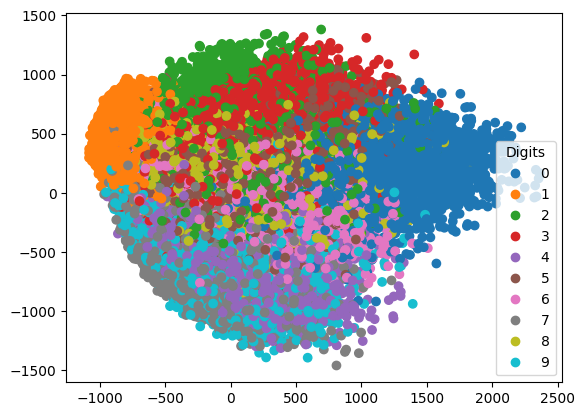

In [13]:
def display_reduction(reduction, ls=train_labels):
    sct = plt.scatter(reduction[:, 0], reduction[:, 1], c=ls, cmap="tab10")
    handles, new_labels = sct.legend_elements()
    plt.legend(handles, new_labels, title="Digits")
    plt.show()

display_reduction(pca.transform(train_images))

C:\Users\fschuller\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


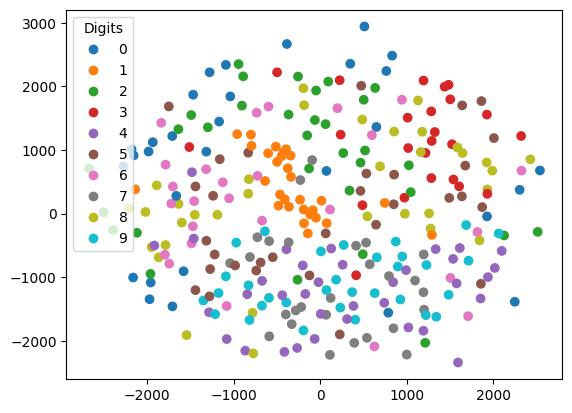

In [14]:
less_data = data.sample(300, random_state=42)
fewer_images = less_data.drop(columns=["label"])
fewer_labels = less_data["label"]

display_reduction(MDS(n_components=2).fit_transform(fewer_images), ls=fewer_labels)

# Kein topologischer "Zusammenhang"...

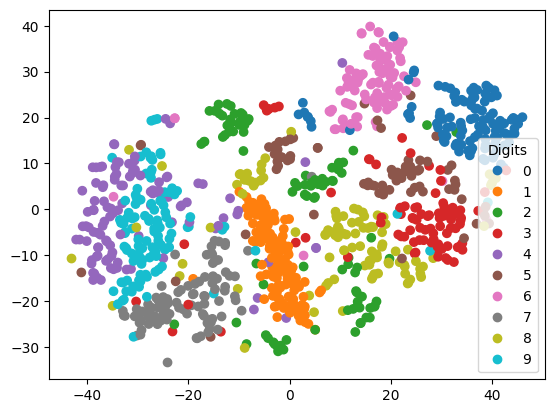

In [15]:
less_train = train.sample(1000, random_state=42)
less_train_images = less_train.drop(columns=["label"])
less_train_labels = less_train["label"]

reduced = TSNE(n_components=2).fit_transform(less_train_images)
display_reduction(reduced, ls=less_train_labels)

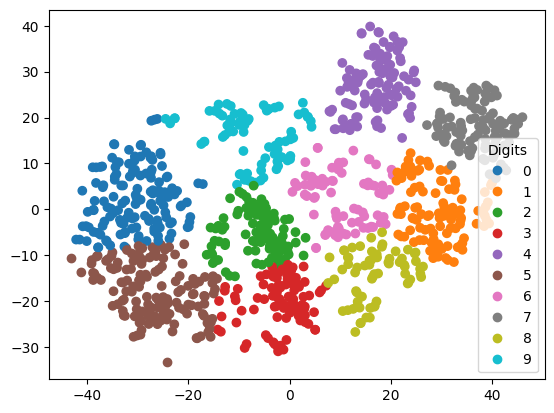

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(reduced)

display_reduction(reduced, ls=clusters)

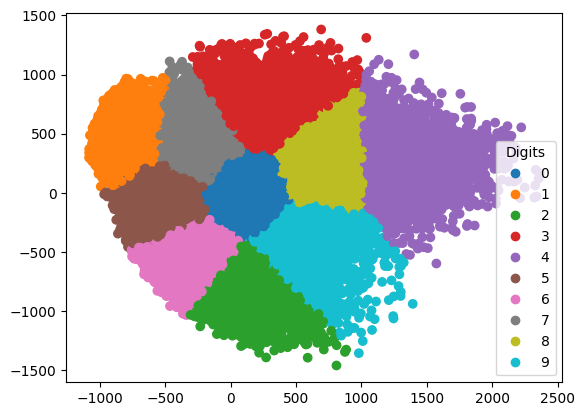

{np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)}


In [17]:
pca_reduction = pca.transform(train_images)
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(pca_reduction)

display_reduction(pca_reduction, ls=clusters)

print(set(clusters))

Erklährte Varianz:  0.7438937222861248


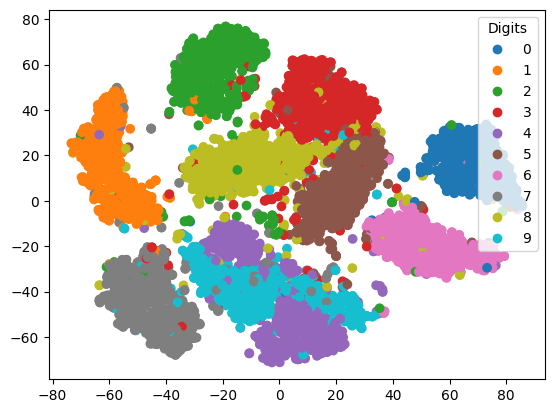

In [36]:
less_train = train.sample(8000, random_state=42)
less_train_images = less_train.drop(columns=["label"])
less_train_labels = less_train["label"]

pca = PCA(n_components=32)
pca_reduction = pca.fit_transform(less_train_images)

print("Erklährte Varianz: ", sum(pca.explained_variance_ratio_))

reduced_2d = TSNE(n_components=2).fit_transform(pca_reduction)
display_reduction(reduced_2d, ls=less_train_labels)

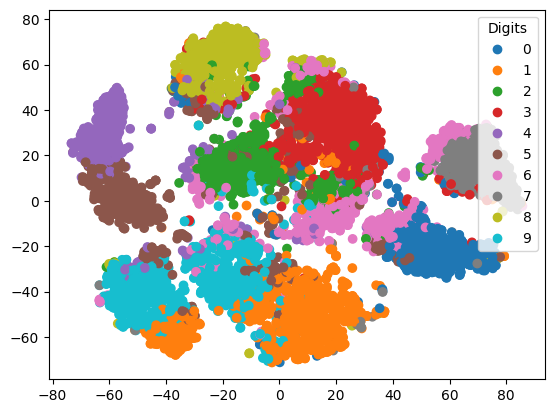

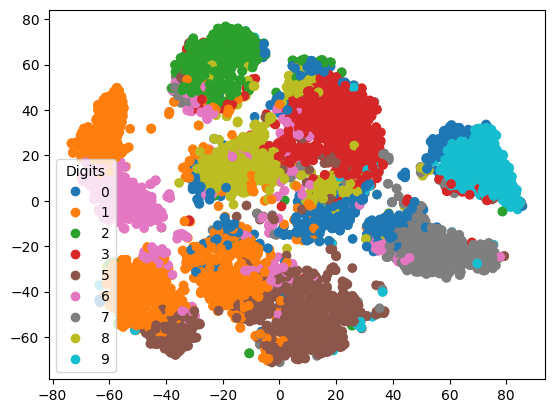

In [37]:
kmeans = KMeans(n_clusters=10, max_iter=1000, random_state=42, n_init=20)
clusters = kmeans.fit_predict(pca_reduction)

display_reduction(reduced_2d, ls=clusters)

# remap the clusters to the labels
remap = list(range(0, 10))

for i in range(0, 10):
    instances = less_train_labels == i
    remap[i] = pd.Series(clusters[instances]).mode().iloc[0]

display_reduction(reduced_2d, ls=[remap[p] for p in clusters])


pred = [remap[p] for p in kmeans.predict(pca.transform(test_images))]

In [38]:
correct = pred == test_labels
count_yes = correct[correct == True].shape[0]
count_no = correct[correct == False].shape[0]
percent_value = count_yes / (count_yes + count_no) * 100
print("The PCA + KMeans Prediction is", percent_value, "% correct, the baseline was 10%")

# Das ist echt schlecht, aber für PCA + KMeans zu erwarten denke ich. Das TSNE diente nur zur Visualisierung, inwiefern die Information erhalten bleibt.

The PCA + KMeans Prediction is 26.80666666666667 % correct, the baseline was 10%


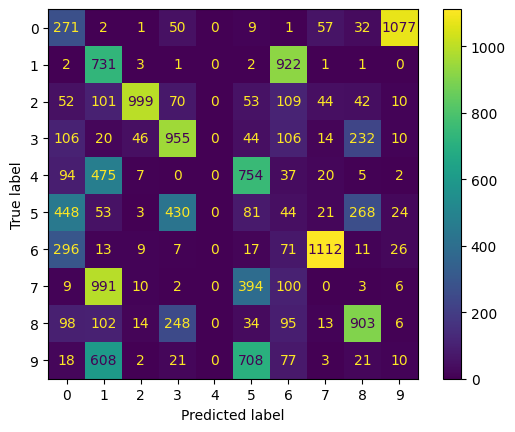

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    y_true=test_labels,
    y_pred=pred
)

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="saga", max_iter=200)
clf.fit(train_images, train_labels)

pred = clf.predict(test_images)

correct = pred == test_labels
count_yes = correct[correct == True].shape[0]
count_no = correct[correct == False].shape[0]
percent_value = count_yes / (count_yes + count_no) * 100
print("The Log Regression is", percent_value, "% correct, the baseline was 10%")

The Log Regression is 91.49333333333334 % correct, the baseline was 10%


C:\Users\fschuller\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

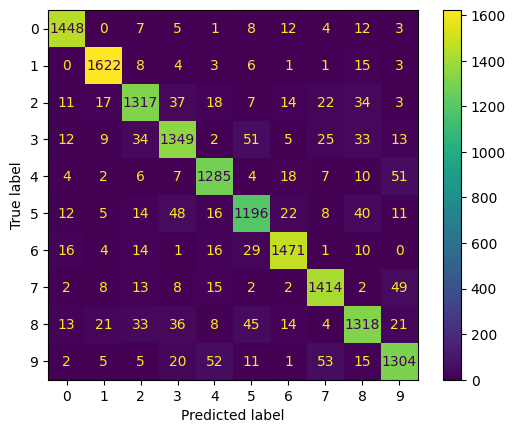

In [23]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=test_labels,
    y_pred=pred
)

In [54]:
def perform_pca_prediction(dims, method="kmeans"):
    pca = PCA(n_components=dims)
    pca_reduction = pca.fit_transform(less_train_images)
    pred = 0
    if method == "kmeans":
        kmeans = KMeans(n_clusters=10, max_iter=1000, random_state=42, n_init=20)
        clusters = kmeans.fit_predict(pca_reduction)
        remap = list(range(0, 10))

        for i in range(0, 10):
            instances = less_train_labels == i
            remap[i] = pd.Series(clusters[instances]).mode().iloc[0]

        pred = [remap[p] for p in kmeans.predict(pca.transform(test_images))]
    elif method == "logreg":
        clf = LogisticRegression(solver="saga")
        clf.fit(pca_reduction, less_train_labels)

        pred = clf.predict(pca.transform(test_images))

    correct = pred == test_labels
    count_yes = correct[correct == True].shape[0]
    count_no = correct[correct == False].shape[0]
    percent_value = count_yes / (count_yes + count_no) * 100
    return percent_value

In [50]:
X = np.arange(20) * 5 + 1
Y = [perform_pca_prediction(x) for x in X]

Text(0, 0.5, 'Accuracy of the Prediction in %')

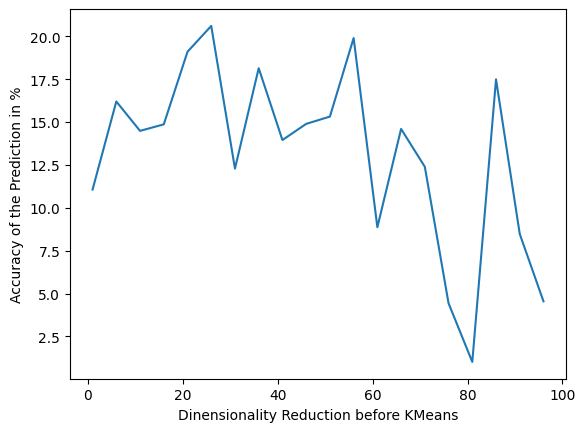

In [51]:
plt.plot(X, Y)
plt.xlabel("Dinensionality Reduction before KMeans")
plt.ylabel("Accuracy of the Prediction in %")

In [ ]:
X = np.arange(10) * 50 + 1
Y2 = [perform_pca_prediction(x, method="logreg") for x in X]

[2 1 3 9 8 4 7 6 5 0]
101 89.46666666666667


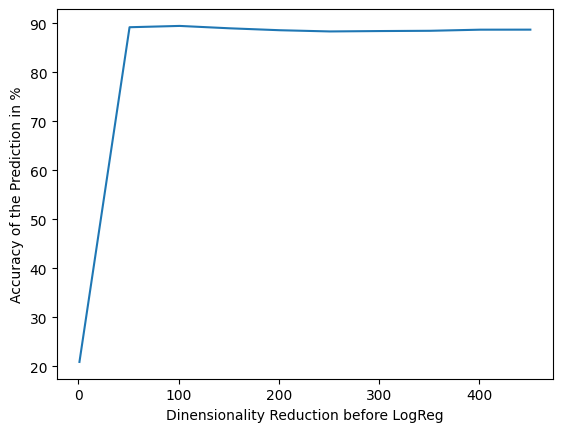

In [67]:
plt.plot(X, Y2)
plt.xlabel("Dinensionality Reduction before LogReg")
plt.ylabel("Accuracy of the Prediction in %")

idx = np.argsort(- np.array(Y2))
print(idx)
print(X[idx[0]], Y2[idx[0]])